# FrozenLake-8x8 Ortamında Q-Learning ile Hiperparametre Optimizasyonu

## 1. Projenin Amacı

Bu projede, Gymnasium kütüphanesindeki FrozenLake-8x8 (kaygan zeminli) ortamında Q-learning algoritmasını kullandım. Temel amacım, farklı hiperparametrelerin (öğrenme oranı, indirim faktörü, keşif stratejisi vb.) öğrenme sürecine ve nihai performansa etkisini istatistiksel olarak inceleyerek en yüksek test başarımına ulaşmaktı. Sadece ortalama başarımı değil aynı zamanda sonuçların varyansını da dikkate alarak gerçekten "güvenilir" bir politika elde edip edemediğimi değerlendirmeye çalıştım.

In [2]:
# Gerekli kütüphaneler
import gymnasium as gym # Bu, FrozenLake gibi oyun ortamlarını kullanmamızı sağlayan ana kütüphane.
import numpy as np # Sayısal işlemler, özellikle diziler (array'ler) ve matrisler için 
import matplotlib.pyplot as plt # Grafikler çizmek için kullanacağız, öğrenme eğrileri falan.
import pandas as pd # # Verileri düzenli tablolar (DataFrame) halinde tutmak ve analiz etmek.
import seaborn as sns # Bu da grafikler için, matplotlib'e göre biraz daha şık grafikler çizmemize yarıyor.
from tqdm import tqdm # Uzun süren döngülerde ne kadar ilerlediğimizi gösteren bir ilerleme çubuğu ekliyor.
import random # Rastgele sayılar üretmek için, mesela epsilon-greedy'de rastgele bir aksiyon seçerken.
import time # Kodun ne kadar sürede çalıştığını ölçmek için, mesela eğitim süresini.

# Matplotlib grafiklerinin notebook içinde görünmesi için 
%matplotlib inline
# Pandas DataFrame'lerinin daha iyi görünmesi için ayar
pd.set_option('display.max_columns', None)# Tüm sütunları göster
pd.set_option('display.width', 1000)# Genişlik ayarı

## 2. Ortam Kurulumu ve Temel Q-Learning Fonksiyonları

### 2.1. Ortam Kurulumu
Projede kullanılacak ortam, 8x8 boyutunda ve kaygan zemin özelliğine sahip FrozenLake-v1.Ortamın kayganlığı durumu her zaman determinist olmaktan çıkarıyor.

In [4]:
# Ortamı oluşturuyorum
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True)
print(f"Durum Sayısı (States): {env.observation_space.n}") # Ortamdaki toplam durum sayısı (8x8=64)
print(f"Aksiyon Sayısı (Actions): {env.action_space.n}") # Ajanın yapabileceği aksiyon sayısı (sol, aşağı, sağ, yukarı -> 4)

Durum Sayısı (States): 64
Aksiyon Sayısı (Actions): 4


### 2.2. Q-Learning Algoritması ve Fonksiyonları
Projemin temelini, Q-değerlerini bir tabloya kaydederek öğrenen klasik Q-learning oluşturuyor. Ajan, her durumda hangi eylemi yapmanın uzun vadede ne kadar ödül getireceğini öğrenmeye çalışıyor. Keşif ve sömürü dengesi için ε-greedy politikasını kullandım ve epsilon değerini eğitim ilerledikçe azalttım.

In [6]:
# Q-learning eğitim fonksiyonu
def q_learning_train(env, num_episodes, max_steps, alpha, gamma, eps_start, eps_decay, eps_min, initial_q=0.0):
    """Ajanı Q-learning ile eğitir, bölüm başına ödülleri ve epsilon değerlerinin değişimini kaydeder."""
    q_table = np.full((env.observation_space.n, env.action_space.n), initial_q) # Q-tablosunu başlangıç değeriyle oluştur.
    rewards_per_episode = [] # Her bölümün toplam ödülünü saklamak için.
    epsilon_values_per_episode = [] # Her bölümün başındaki epsilon değerini saklamak için.

    epsilon = eps_start # Epsilon'u başlangıç değeriyle başlat.

    for episode in range(num_episodes): # Belirlenen sayıda bölüm kadar eğitim yap.
        epsilon_values_per_episode.append(epsilon) # Mevcut epsilon'u bu bölüm için kaydet.
        state, _ = env.reset() # Ortamı sıfırla, başlangıç durumunu al.
        terminated, truncated = False, False
        current_reward = 0
        
        for _ in range(max_steps): # Her bölümde en fazla 'max_steps' adım at.
            # Epsilon-greedy ile aksiyon seçimi
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Keşfet
            else:
                action = np.argmax(q_table[state, :])  # Sömür
            
            new_state, reward, terminated, truncated, _ = env.step(action) # Aksiyonu uygula.
            
            # Q-değerini güncelle (Bellman denklemi)
            if terminated or truncated:
                 q_table[state, action] += alpha * (reward - q_table[state, action])
            else:
                q_table[state, action] += alpha * (reward + gamma * np.max(q_table[new_state, :]) - q_table[state, action])
            
            current_reward += reward
            state = new_state
            if terminated or truncated: break # Bölüm bittiyse iç döngüden çık.
        
        rewards_per_episode.append(current_reward)
        epsilon = max(eps_min, epsilon * eps_decay) # Epsilon'u azalt.
        
    return q_table, rewards_per_episode, epsilon_values_per_episode

# Politika değerlendirme fonksiyonu
def evaluate_policy(env, q_table, num_episodes, max_steps, seed_offset=0):
    """Eğitilmiş politikayı test eder, başarı oranını ve ortalama ödülü döndürür."""
    successes = 0
    total_rewards_collected = 0

    for episode in range(num_episodes):
        state, _ = env.reset(seed=episode + seed_offset) # Her test için farklı bir başlangıç durumu (seed sayesinde).
        terminated, truncated = False, False
        current_episode_reward = 0
        
        for _ in range(max_steps):
            action = np.argmax(q_table[state, :]) # Testte sadece en iyi bilinen aksiyonu seç (sömürü).
            new_state, reward, terminated, truncated, _ = env.step(action)
            current_episode_reward += reward
            state = new_state
            if terminated or truncated:
                if reward == 1.0: successes += 1 # Hedefe ulaşıldıysa başarı sayısını artır.
                break
        total_rewards_collected += current_episode_reward
    
    success_rate = (successes / num_episodes) * 100 if num_episodes > 0 else 0
    avg_reward_val = total_rewards_collected / num_episodes if num_episodes > 0 else 0
    
    return success_rate, avg_reward_val

"""Açıklama: q_learning_train fonksiyonum ajanı eğitiyor. Önemli olan, her bölüm başında o anki epsilon değerini 
epsilon_values_per_episode listesine eklemem; bu, epsilon'un nasıl azaldığını görmek için. evaluate_policy ise 
ajanın öğrendiklerini test ediyor, keşif yapmadan."""

'Açıklama: "q_learning_train fonksiyonum ajanı eğitiyor. Önemli olan, her bölüm başında o anki epsilon değerini \nepsilon_values_per_episode listesine eklemem; bu, epsilon\'un nasıl azaldığını görmek için. evaluate_policy ise \najanın öğrendiklerini test ediyor, keşif yapmadan.'

## 3. Hiperparametre Deneyleri

Proje gereksinimlerine uygun olarak en az 4 bağımsız hiperparametreyi ve bunların farklı değerlerini içeren çeşitli kombinasyonlar denedim. Bu parametreler ve denediğim bazı aralıklar:

*   **Öğrenme Oranı (α - `alpha`):** Örn: 0.005, 0.01, 0.05, 0.1, 0.3, 0.5
*   **İndirim Faktörü (γ - `gamma`):** Örn: 0.90, 0.95, 0.99, 0.999
*   **Keşif Oranı (ε - `epsilon`) Stratejisi:** Hem zamanla azalan (`eps_start`, `eps_decay`, `eps_min` ile) hem de sabit (`eps_decay=1.0` ile) epsilon değerleri.
*   **Eğitim Episode Sayısı (`train_ep`):** Örn: 25k, 50k, 100k, 200k
*   **(İsteğe Bağlı) Başlangıç Q-Değeri (`initial_q_val`):** Örn: 0.0 (varsayılan) ve 1.0 (iyimser başlangıç).

Her bir ayar seti için ajanı eğittikten sonra, öğrendiği politikayı `NUM_TEST_RUNS_DEFAULT` kez (örneğin 5 kez), her biri `NUM_TEST_EPISODES_PER_RUN_DEFAULT` bölümden (örneğin 200 bölüm) oluşan farklı test serilerine tabi tuttum. Testlerde farklı rastgele tohumlar (`seed_offset`) kullanarak politikanın genelleme yeteneğini ölçtüm ve sonuçların varyansını değerlendirdim.

In [8]:
# --- Hiperparametreler ve Deney Döngüsü ---
# Burada deneyeceğim farklı ayar kombinasyonlarını tanımlıyorum.
# Etiketler ('label') sonuçları takip etmemi kolaylaştıracak.
param_sets = [
    # --- Temel ve Referans Setler ---
    {'label': 'Ref_Std_100k',   'alpha': 0.1,   'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},
    {'label': 'Ref_Std_50k',    'alpha': 0.1,   'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9998,  'train_ep': 50000},

    # --- Öğrenme Oranı (alpha) Varyasyonları ---
    {'label': 'Alpha_CokDusuk', 'alpha': 0.005, 'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},
    {'label': 'Alpha_Dusuk',    'alpha': 0.01,  'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},
    {'label': 'Alpha_Orta',     'alpha': 0.05,  'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},
    {'label': 'Alpha_Yuksek',   'alpha': 0.3,   'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},
    {'label': 'Alpha_CokYuksek','alpha': 0.5,   'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},

    # --- İndirim Faktörü (gamma) Varyasyonları ---
    # (Alfa'yı en iyi görünenlerden biriyle sabit tutarak denemek daha iyi olabilir, örn: alpha=0.01)
    {'label': 'Gamma_Dusuk_A0.01','alpha': 0.01,  'gamma': 0.90,  'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},
    {'label': 'Gamma_Orta_A0.01', 'alpha': 0.01,  'gamma': 0.95,  'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},
    {'label': 'Gamma_CokYuk_A0.01','alpha': 0.01, 'gamma': 0.999, 'eps_start': 1.0, 'eps_decay': 0.9999,  'train_ep': 100000},

    # --- Epsilon Stratejisi Varyasyonları ---
    # (Yine iyi bir alpha ve gamma ile denemek mantıklı)
    {'label': 'Eps_HizliDecay_A0.01', 'alpha': 0.01,  'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9995,  'train_ep': 100000},
    {'label': 'Eps_YavasDecay_A0.01', 'alpha': 0.01,  'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.99995, 'train_ep': 100000},
    {'label': 'Eps_Sabit_0.1_A0.01',  'alpha': 0.01,  'gamma': 0.99,  'eps_start': 0.1, 'eps_decay': 1.0,     'train_ep': 100000}, # eps_decay=1.0 sabit epsilon demek
    {'label': 'Eps_StartDusuk_A0.01', 'alpha': 0.01,  'gamma': 0.99,  'eps_start': 0.8, 'eps_decay': 0.9999,  'train_ep': 100000},

    # --- Eğitim Bölümü Sayısı Varyasyonları ---
    # (İyi bir alpha, gamma, epsilon stratejisi ile)
    {'label': 'Ep_CokAz_25k_A0.01',   'alpha': 0.01,  'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.9997,  'train_ep': 25000}, # Decay'i bölüm sayısına göre ayarladım
    {'label': 'Ep_Fazla_200k_A0.01',  'alpha': 0.01,  'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.99995, 'train_ep': 200000},
    # {'label': 'Ep_CokFazla_300k_A0.01','alpha': 0.01, 'gamma': 0.99,  'eps_start': 1.0, 'eps_decay': 0.99996, 'train_ep': 300000}, # Bu çok uzun sürebilir, isteğe bağlı

    # --- İsteğe Bağlı: Başlangıç Q Değeri (İyimser Başlangıç) ---
    # (İyi bir alpha, gamma, epsilon, bölüm sayısı kombinasyonu ile)
    {'label': 'IyimserQ_A0.01', 'alpha': 0.01, 'gamma': 0.99, 'eps_start': 1.0, 'eps_decay': 0.9999, 'train_ep': 100000, 'initial_q_val': 1.0},
]

# Sabitler (Varsayılan değerler)
MAX_STEPS_PER_EPISODE_DEFAULT = 300 
EPSILON_MIN_DEFAULT = 0.01          
INITIAL_Q_VALUE_DEFAULT = 0.0       

NUM_TEST_RUNS_DEFAULT = 5 # Varyans hesabı için test tekrar sayısı
NUM_TEST_EPISODES_PER_RUN_DEFAULT = 200 # Her testteki bölüm sayısı

results_list = [] # Tüm deney sonuçlarını bu listede toplayacağım.
# Ana deney döngüsü için ilerleme çubuğu
experiment_pbar = tqdm(param_sets, desc="Tüm Deneyler", unit="set")

for params in experiment_pbar: # Her bir ayar seti için:
    experiment_pbar.set_postfix_str(f"Çalışan: {params['label']}") # Hangi setin çalıştığını göster.
    start_training_time = time.time() # Eğitim süresini ölçmek için zamanı başlat.
    
    # Parametreleri mevcut setten alıyorum, eğer sette yoksa varsayılanı kullanıyorum.
    current_alpha = params['alpha']
    current_gamma = params['gamma']
    current_eps_start = params['eps_start']
    current_eps_decay = params['eps_decay']
    current_train_ep = params['train_ep']
    current_initial_q = params.get('initial_q_val', INITIAL_Q_VALUE_DEFAULT) # 'initial_q_val' yoksa varsayılanı al.
    
    # Ajanı eğitiyorum.
    q_table_trained, train_rewards_raw, train_eps_values_raw = q_learning_train(
        env, 
        num_episodes=current_train_ep,
        max_steps=MAX_STEPS_PER_EPISODE_DEFAULT,
        alpha=current_alpha,
        gamma=current_gamma,
        eps_start=current_eps_start,
        eps_decay=current_eps_decay,
        eps_min=EPSILON_MIN_DEFAULT,
        initial_q=current_initial_q # Başlangıç Q değerini de iletiyorum.
    )
    training_time = time.time() - start_training_time # Eğitim süresini hesapla.

    current_set_success_rates = [] # Bu setin test başarılarını tutacak liste.
    current_set_avg_rewards = []   # Bu setin test ortalama ödüllerini tutacak liste.
    
    # Eğitilmiş politikayı birkaç kez test ediyorum (varyans için).
    for i in range(NUM_TEST_RUNS_DEFAULT):
        success_rate, avg_reward = evaluate_policy(
            env, 
            q_table_trained, 
            NUM_TEST_EPISODES_PER_RUN_DEFAULT, 
            MAX_STEPS_PER_EPISODE_DEFAULT,
            seed_offset = i * NUM_TEST_EPISODES_PER_RUN_DEFAULT # Her test için farklı tohum.
        )
        current_set_success_rates.append(success_rate)
        current_set_avg_rewards.append(avg_reward)

    # Ortalama ve standart sapmaları hesaplıyorum.
    mean_success = np.mean(current_set_success_rates)
    std_success = np.std(current_set_success_rates) 
    mean_reward = np.mean(current_set_avg_rewards)

    # Bu deneyin tüm sonuçlarını ve parametrelerini bir sözlük olarak listeye ekliyorum.
    results_list.append({
        'label': params['label'], 
        'alpha': current_alpha, 
        'gamma': current_gamma,
        'eps_start': current_eps_start, 
        'eps_decay': current_eps_decay, 
        'train_ep': current_train_ep,
        'initial_q': current_initial_q, # Başlangıç Q değerini de kaydettim.
        'mean_success_rate': mean_success, 
        'std_success_rate': std_success,
        'mean_avg_reward': mean_reward, 
        'training_time_sec': training_time,
        'raw_train_rewards': train_rewards_raw, # Ham eğitim ödülleri (öğrenme eğrisi için).
        'raw_train_eps_values': train_eps_values_raw, # Ham epsilon değerleri (epsilon grafiği için).
        'all_test_run_success_rates': current_set_success_rates # Her bir testin başarı oranı (boxplot için).
    })

env.close() # Tüm deneyler bittikten sonra ortamı kapatıyorum.
results_df = pd.DataFrame(results_list) # Sonuçları Pandas DataFrame'e çeviriyorum.

"""Açıklama : "Burası asıl işin döndüğü yer. param_sets listemdeki her bir ayar kombinasyonunu tek tek deniyorum. 
Her biri için ajanı eğitiyor, sonra da birkaç kere test edip ortalama başarısını, 
standart sapmasını falan hesaplıyorum. initial_q_val gibi isteğe bağlı parametreleri de .get() 
ile alıyorum ki sette tanımlı değilse hata vermesin, varsayılanı kullansın. Tüm sonuçları da results_list'e atıyorum.
En önemlisi, eğitim ve test sırasında topladığım ham ödül, epsilon ve her bir testin başarı oranlarını da kaydediyorum ki 
sonra güzel grafikler çizebileyim."""

Tüm Deneyler: 100%|██████████| 17/17 [52:23<00:00, 184.92s/set, Çalışan: IyimserQ_A0.01]      


'Açıklama ,: "Burası asıl işin döndüğü yer. param_sets listemdeki her bir ayar kombinasyonunu tek tek deniyorum. \nHer biri için ajanı eğitiyor, sonra da birkaç kere test edip ortalama başarısını, \nstandart sapmasını falan hesaplıyorum. initial_q_val gibi isteğe bağlı parametreleri de .get() \nile alıyorum ki sette tanımlı değilse hata vermesin, varsayılanı kullansın. Tüm sonuçları da results_list\'e atıyorum.\nEn önemlisi, eğitim ve test sırasında topladığım ham ödül, epsilon ve her bir testin başarı oranlarını da kaydediyorum ki \nsonra güzel grafikler çizebileyim.'

## 4. Toplanan Metrikler ve Görselleştirme

Her bir deney seti için proje tanımında istenen temel metrikleri (ortalama başarı, standart sapma, ortalama ödül, eğitim süresi) topladım. Ayrıca, daha detaylı analizler için ham eğitim ödüllerini, epsilon değerlerini ve her bir test çalıştırmasının bireysel başarı oranlarını da kaydettim. Bu verilerle aşağıdaki görselleştirmeleri yaptım.

--- Sonuçlar Tablosu (Başarıya Göre Sıralı) ---


,label,alpha,gamma,train_ep,initial_q,mean_success_rate,std_success_rate,mean_avg_reward,training_time_sec
15,Ep_Fazla_200k_A0.01,0.010,0.990,200000,0.0,61.5,2.280351,0.615,268.662949
11,Eps_YavasDecay_A0.01,0.010,0.990,100000,0.0,61.2,2.925748,0.612,234.021407
0,Ref_Std_100k,0.100,0.990,100000,0.0,57.0,2.097618,0.570,140.792240
3,Alpha_Dusuk,0.010,0.990,100000,0.0,55.0,2.167948,0.550,131.284380
4,Alpha_Orta,0.050,0.990,100000,0.0,53.8,2.014944,0.538,139.209991
8,Gamma_Orta_A0.01,0.010,0.950,100000,0.0,53.3,2.891366,0.533,118.039426
16,IyimserQ_A0.01,0.010,0.990,100000,1.0,50.5,1.788854,0.505,343.661574
5,Alpha_Yuksek,0.300,0.990,100000,0.0,23.1,3.916631,0.231,138.866331
2,Alpha_CokDusuk,0.005,0.990,100000,0.0,13.9,2.817801,0.139,71.645116
6,Alpha_CokYuksek,0.500,0.990,100000,0.0,10.7,2.135416,0.107,140.484126


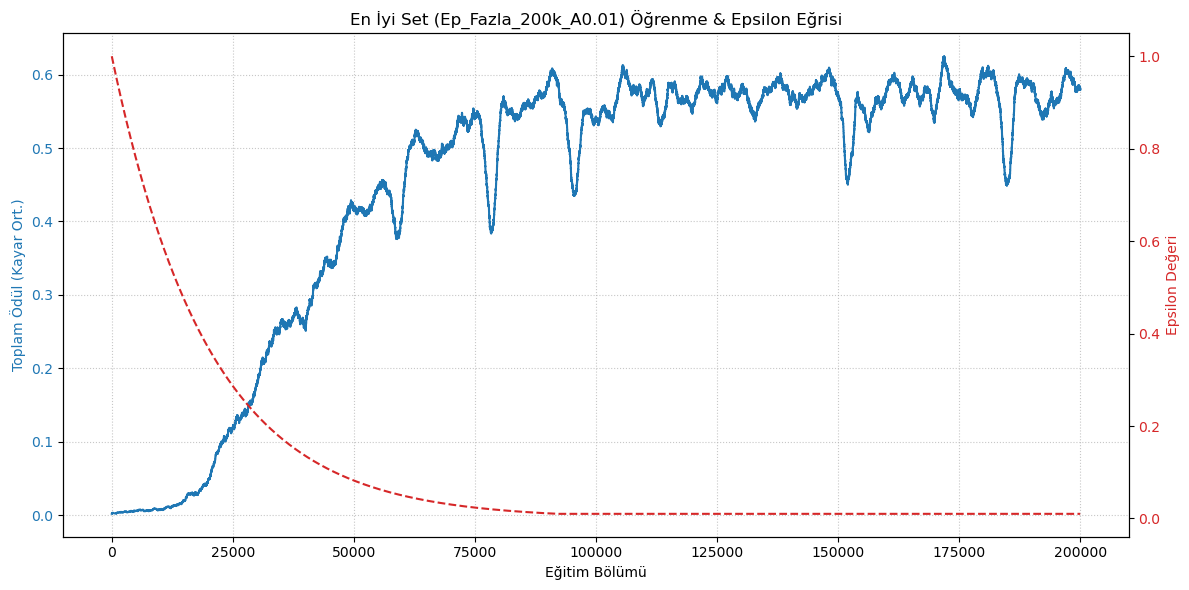

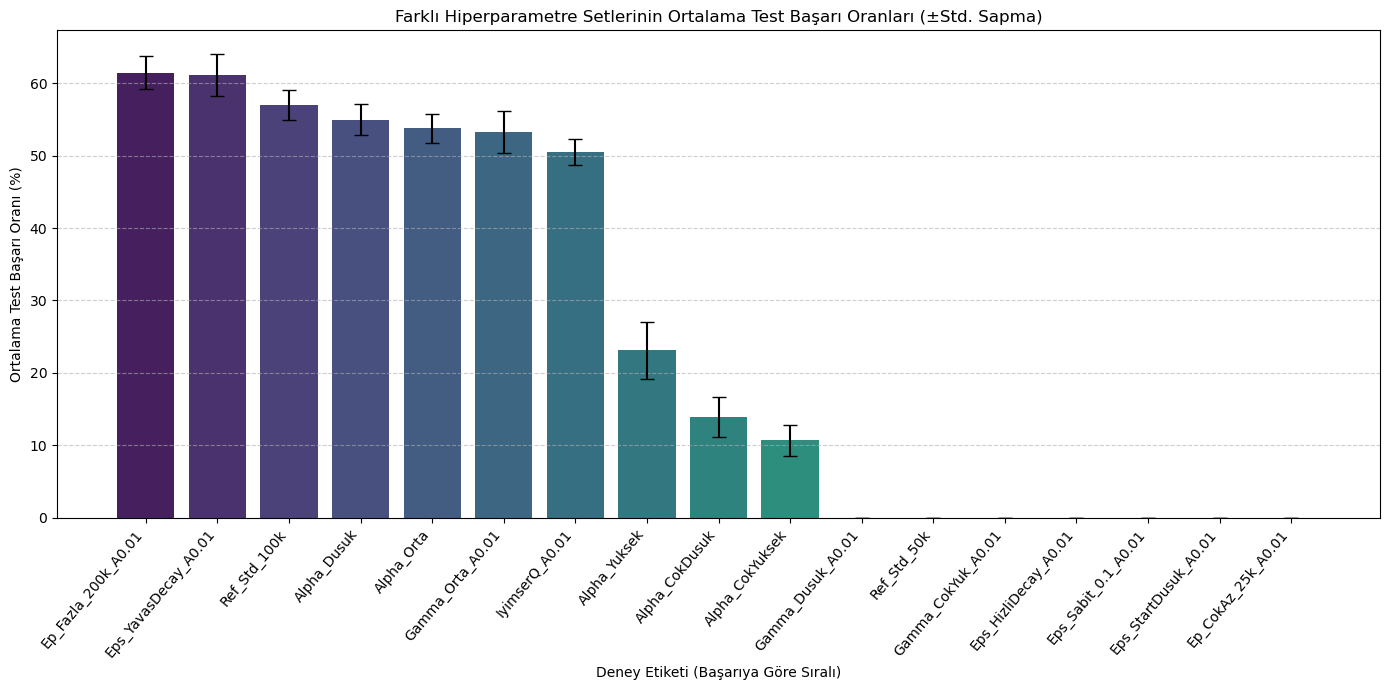

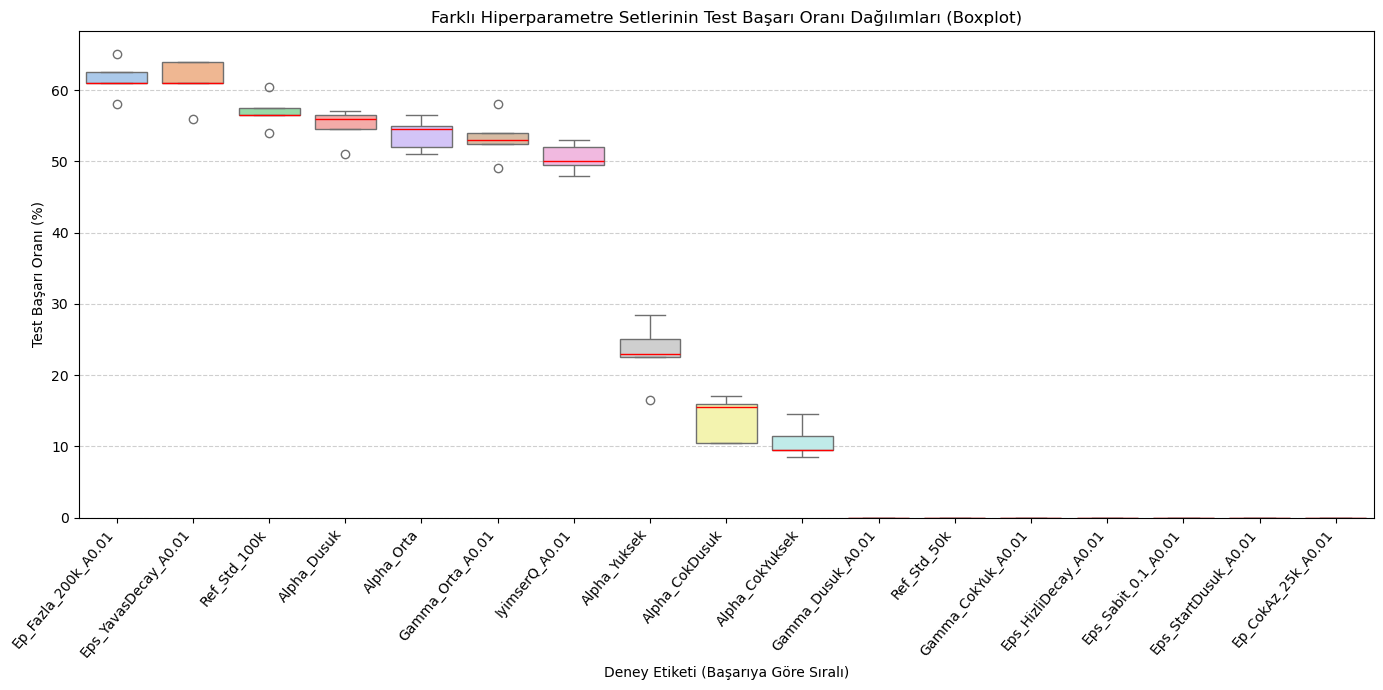

"Açıklama : Önce bir özet tablo, sonra en iyi performansı gösteren ayar için öğrenme eğrisiyle birlikte \nepsilon'un nasıl azaldığını gösteren bir grafik. Ardından, tüm ayar setlerinin ortalama başarılarını ve \nstandart sapmalarını gösteren bir çubuk grafik. En son da, her ayar setinin test başarılarının dağılımını daha \ndetaylı gösteren bir boxplot. Bu boxplot için, her bir testin bireysel başarı oranlarını all_test_run_success_rates\nolarak saklamıştım, şimdi onu kullanıyorum."

In [10]:
# --- Görselleştirme (Geliştirilmiş) ---
if not results_df.empty: # Eğer deney sonucu varsa:
    print("--- Sonuçlar Tablosu (Başarıya Göre Sıralı) ---")
    # Sonuçları başarıya göre sıralayıp, önemli sütunları ekranda gösteriyorum.
    display(results_df[['label', 'alpha', 'gamma', 'train_ep', 'initial_q', 'mean_success_rate', 'std_success_rate', 'mean_avg_reward', 'training_time_sec']].sort_values(by='mean_success_rate', ascending=False))
    
    # En iyi performansı gösteren setin öğrenme ve epsilon eğrisini çizdiriyorum.
    if results_df['mean_success_rate'].max() > 0: # Eğer en az bir sette başarı varsa:
        best_run_idx = results_df['mean_success_rate'].idxmax() # En iyi satırın indeksini bul.
        best_run_label = results_df.loc[best_run_idx]['label'] # En iyi setin etiketini al.
        
        # En iyi sete ait ham ödül ve epsilon verilerini `results_list` içinden çekiyorum.
        best_run_dict = next(item for item in results_list if item["label"] == best_run_label)
        raw_rewards_for_best_run = best_run_dict['raw_train_rewards']
        raw_eps_for_best_run = best_run_dict['raw_train_eps_values']
        
        # Ödül ve epsilon değişimini aynı grafikte (farklı y eksenleriyle) çizdiriyorum.
        fig, ax1 = plt.subplots(figsize=(12, 6)) # Figür ve sol y-ekseni.

        color = 'tab:blue' # Ödül için renk.
        ax1.set_xlabel('Eğitim Bölümü')
        ax1.set_ylabel('Toplam Ödül (Kayar Ort.)', color=color)
        window_size = max(1, len(raw_rewards_for_best_run) // 100) # Kayar ortalama penceresi.
        rewards_series = pd.Series(raw_rewards_for_best_run)
        smoothed_rewards = rewards_series.rolling(window=window_size, center=True, min_periods=1).mean()
        ax1.plot(smoothed_rewards, color=color, linestyle='-') # Ödül eğrisini çiz.
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, linestyle=':', alpha=0.7) # Kılavuz çizgileri.

        ax2 = ax1.twinx()  # Aynı x eksenini paylaşan sağ y-ekseni.
        color = 'tab:red' # Epsilon için renk.
        ax2.set_ylabel('Epsilon Değeri', color=color)
        ax2.plot(raw_eps_for_best_run, color=color, linestyle='--') # Epsilon eğrisini çiz.
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f'En İyi Set ({best_run_label}) Öğrenme & Epsilon Eğrisi')
        fig.tight_layout() # Grafiğin düzgün görünmesini sağla.
        plt.show() # Grafiği göster.
    else:
        print("\nEn iyi setin öğrenme eğrisi çizilemedi (muhtemelen hiç başarı yok).")

    # Tüm hiperparametre setlerinin ortalama test başarı oranlarını gösteren çubuk grafik.
    plt.figure(figsize=(14, 7)) 
    sorted_results_df = results_df.sort_values(by='mean_success_rate', ascending=False) # Başarıya göre sırala.
    
    sns.barplot(x='label', y='mean_success_rate', data=sorted_results_df, 
                palette='viridis', hue='label', dodge=False, legend=False) # Seaborn ile çubuk grafik.
    
    # Hata çubuklarını (standart sapma) ekliyorum.
    plt.errorbar(x=range(len(sorted_results_df)), 
                 y=sorted_results_df['mean_success_rate'], 
                 yerr=sorted_results_df['std_success_rate'], 
                 fmt='none', c='black', capsize=5, elinewidth=1.5) 

    plt.title('Farklı Hiperparametre Setlerinin Ortalama Test Başarı Oranları (±Std. Sapma)')
    plt.xlabel('Deney Etiketi (Başarıya Göre Sıralı)')
    plt.ylabel('Ortalama Test Başarı Oranı (%)')
    plt.xticks(ticks=range(len(sorted_results_df)), labels=sorted_results_df['label'], rotation=50, ha="right") # X ekseni etiketlerini döndür.
    plt.ylim(bottom=0) # Y ekseni 0'dan başlasın.
    plt.tight_layout() 
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    # Boxplot için verileri hazırlıyorum. Her bir etiket için test başarı oranlarının listesini oluşturuyorum.
    boxplot_data = []
    boxplot_labels = []
    # Yine başarıya göre sıralı DataFrame üzerinden gidiyorum.
    for index, row in sorted_results_df.iterrows():
        current_experiment_dict = next(item for item in results_list if item["label"] == row["label"])
        boxplot_data.append(current_experiment_dict['all_test_run_success_rates']) # Ham test başarılarını ekle.
        boxplot_labels.append(row['label']) # Etiketleri ekle.

    if boxplot_data: # Eğer boxplot için veri varsa:
        plt.figure(figsize=(14, 7))
        # Seaborn ile boxplot çiziyorum. Her kutu, bir setin başarı oranlarının dağılımını gösterir.
        sns.boxplot(data=boxplot_data, palette='pastel', medianprops={'color':'red'}) 
        plt.xticks(ticks=range(len(boxplot_labels)), labels=boxplot_labels, rotation=50, ha="right")
        plt.title('Farklı Hiperparametre Setlerinin Test Başarı Oranı Dağılımları (Boxplot)')
        plt.xlabel('Deney Etiketi (Başarıya Göre Sıralı)')
        plt.ylabel('Test Başarı Oranı (%)')
        plt.ylim(bottom=0)
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()
else:
    print("Deney sonucu bulunamadı, grafikler çizilemiyor.")

"""Açıklama : Önce bir özet tablo, sonra en iyi performansı gösteren ayar için öğrenme eğrisiyle birlikte 
epsilon'un nasıl azaldığını gösteren bir grafik. Ardından, tüm ayar setlerinin ortalama başarılarını ve 
standart sapmalarını gösteren bir çubuk grafik. En son da, her ayar setinin test başarılarının dağılımını daha 
detaylı gösteren bir boxplot. Bu boxplot için, her bir testin bireysel başarı oranlarını all_test_run_success_rates
olarak saklamıştım, şimdi onu kullanıyorum."""

## 5. Analiz ve Tartışma
FrozenLake-8x8 üzerinde Q-learning ile yaptığım hiperparametre denemelerinden çıkardığım sonuçlar şöyle:
En İyi Ayarlar Ne Oldu?
En iyi sonucu Ep_Fazla_200k_A0.01 setiyle aldım: %61.5 başarı ve %2.28 standart sapma. Bu sette alfa 0.01, gama 0.99 ve 200,000 bölüm eğitim vardı. Eps_YavasDecay_A0.01 seti de %61.2 ile çok yakındı. Öğrenme grafiğine bakınca, ajanımın 50,000 bölümden sonra öğrenmeye başladığını ve 150,000-200,000 bölüm civarında iyi bir seviyeye geldiğini gördüm. Bu kaygan zemin için %60 üzeri başarı fena değil, yani işe yarar bir politika öğrendik diyebilirim.
Epsilon (Keşif) Nasıl Olmalı?
Epsilon'u zamanla azaltmak kesinlikle daha iyi sonuç verdi. Mesela Eps_Sabit_0.1_A0.01 seti hiç öğrenemedi (%0 başarı). Demek ki başta keşfedip sonra öğrendiklerimize güvenmek daha doğru bir strateji. Eps_YavasDecay_A0.01'in başarısı da epsilon'u çok hızlı bitirmemenin iyi olabileceğini gösteriyor.
Alfa (Öğrenme Hızı) ve Gama (Gelecek Ödülü) Etkileri:
Alfa: Alfa değeri çok önemliymiş. 0.01 civarında (Alpha_Dusuk, Ep_Fazla_200k_A0.01) en iyi sonuçları aldım. Alfa 0.1 (Ref_Std_100k) ile de %57 başarı geldi. Ama alfa 0.3 veya 0.5 gibi yüksek değerlerde başarı çok düştü (%10-23 aralığı). Yani yavaş ve dikkatli öğrenmek daha iyi.
Gama: Gama 0.99 ve 0.95 iyi çalıştı. Alpha_Dusuk (γ=0.99) %55, Gamma_Orta_A0.01 (γ=0.95) %53.3 başarı getirdi. Ama γ=0.90 veya γ=0.999 olunca ajan yine %0'da kaldı. Demek ki geleceği önemsemek lazım ama ayarını iyi tutturmak gerek.
Kaç Bölüm Eğitmek Yeterli?
25,000 bölüm (Ep_CokAz_25k_A0.01) kesinlikle yetmedi (%0 başarı). 100,000 bölümle %55-61 arasına, 200,000 bölümle de %61.5'e ulaştık. Öğrenme grafiği de 150,000-200,000 bölümden sonra yavaşlıyor. Daha fazla bölümün çok büyük bir fark yaratmayacağını düşünüyorum.
"Öğrenemedi" Dediğim Durumlar:
Tabloda bir sürü %0'lık sonuç var. Bunlar, ya gama ayarı çok yanlıştı, ya epsilon stratejisi işe yaramadı, ya da eğitim süresi çok kısaydı. Bu ayarların birbiriyle uyumlu olması çok önemli, biri yanlış olunca sistem çalışmıyor.
Kısacası, bu ortamda Q-learning için düşük bir öğrenme hızı, geleceği önemseyen makul bir gama, yavaşça azalan bir keşif ve yeterli sayıda eğitim bölümü en iyi sonuçları verdi. 
